In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south_13_09.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
df_cultura = df_cultura[df_cultura['decade']>=-800]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
df_individuals = df_individuals[df_individuals['decade']>=-800]


df_individuals = df_individuals[df_individuals['region_name'].isin(['Northern China', 'Southern China'])]
df_individuals.sort_values('score', ascending=False)


# Filtering logic
df = df_cultura[df_cultura['region_name'].isin(['Northern China', 'Southern China'])]
df = df[df['decade'] >= -800]
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log

# # Append entries for -800 for both regions with all values set to 0
# new_entries = pd.DataFrame({
#     'region_name': ['Northern China', 'Southern China'],
#     'decade': [-800, -800],
#     'N_est': [0, 0],
#     'N_est_min': [0, 0],
#     'N_est_max': [0, 0],
#     'score': [0, 0]
# })

# # Append the new entries to the existing DataFrame
# df = pd.concat([df, new_entries], ignore_index=True)


In [2]:
df_individuals

,individual_wikidata_id,productive_year,decade,individual_name,score,region_name
1966,Q1005462,1593.0,1590,Chen Jiru,33,Southern China
2046,Q10061,1598.0,1600,Wanli Emperor,24,Northern China
3516,Q1017028,1647.0,1650,Zhou Lianggong,26,Northern China
3557,Q1018002,630.0,630,Cen Wenben,13,Southern China
4287,Q1021962,1766.0,1770,Yongqi,6,Northern China
...,...,...,...,...,...,...
608528,Q986653,636.0,640,Ma Zhou,5,Northern China
611809,Q994515,1627.0,1630,Giacomo Rho,18,Northern China
612725,Q9977,1434.0,1430,Xuande Emperor,24,Northern China
612931,Q9991,1482.0,1480,Chenghua Emperor,16,Northern China


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_82832/1759225405.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.sort_values(by='decade', inplace=True)


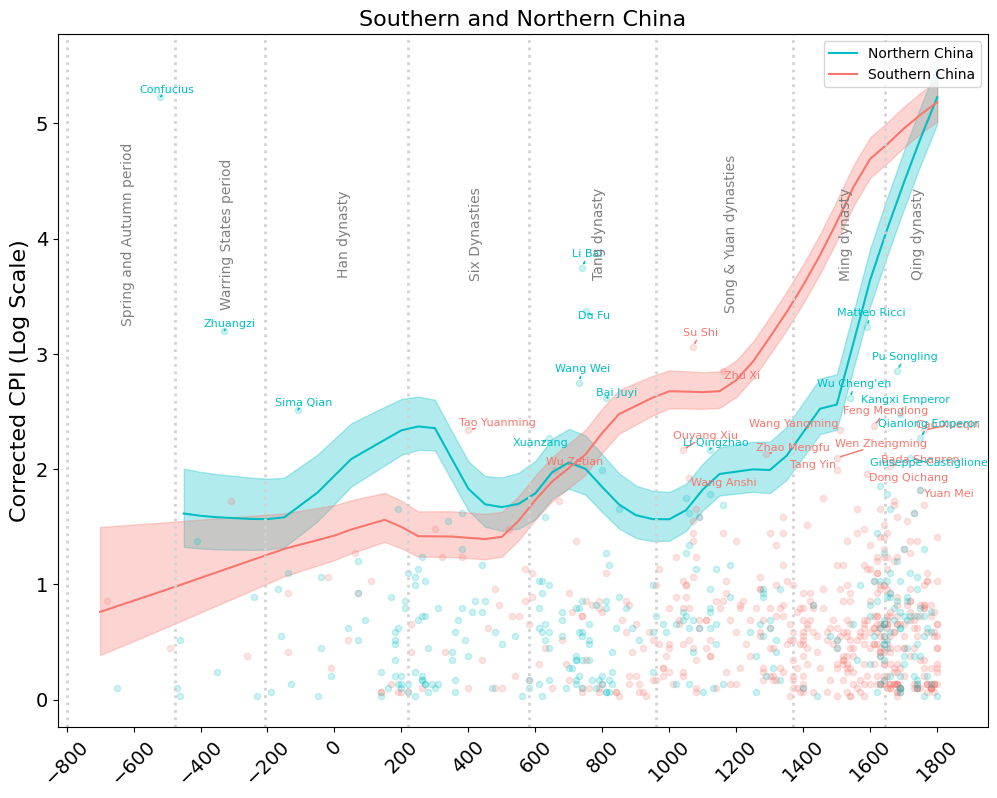

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from adjustText import adjust_text

# Assuming data loading and preparation as done previously in your script

# Define your color scheme
colors = {
    "Northern China": "#00bfc4",
    "Southern China": "#f8766d"
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing

    frac = 0.25
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(15).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color=colors[region],fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))


period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Southern and Northern China', fontsize = 16)
ax.legend()
plt.show()


### China

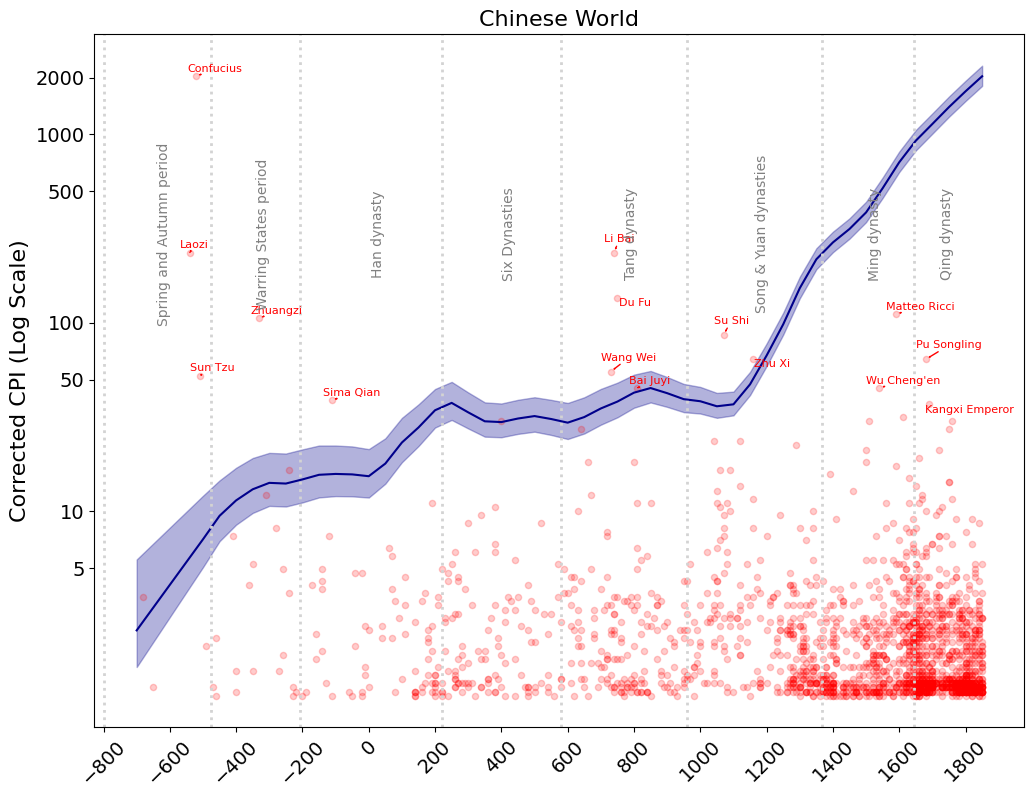

In [4]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south_china.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]
df_cultura = df_cultura[df_cultura['decade']>=-800]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1850]
df_individuals = df_individuals[df_individuals['decade']>=-800]


df_individuals = df_individuals[df_individuals['region_name'].isin(['Chinese world'])]
df_individuals.sort_values('score', ascending=False)


# Filtering logic
df = df_cultura[df_cultura['region_name'].isin(['Chinese world'])]
df = df[df['decade'] >= -800]
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log



# Define your color scheme
colors = {
    "Chinese world": "#00008b",
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=0.2)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(15).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color='red',fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))


period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')




# Define specific y-ticks and convert them to log scale for plotting
yticks = [5, 10, 50, 100, 500, 1000, 2000]
yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Chinese World', fontsize = 16)
ax.legend().remove()
plt.show()


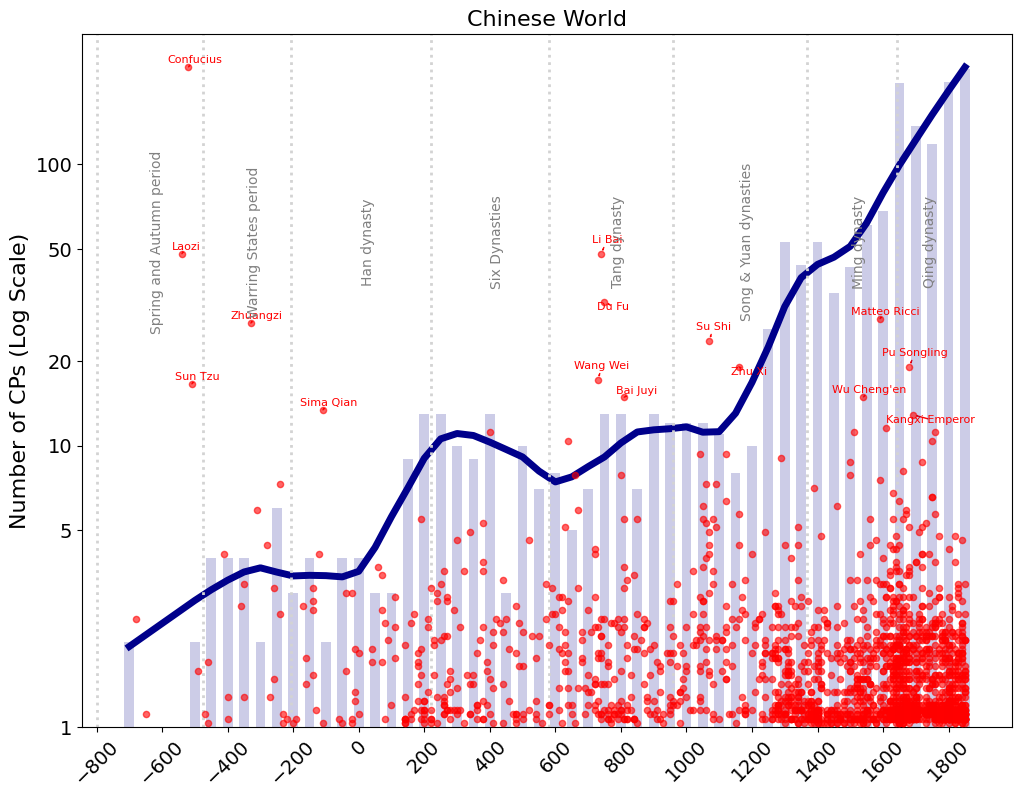

In [27]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south_china.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]
df_cultura = df_cultura[df_cultura['decade']>=-800]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1850]
df_individuals = df_individuals[df_individuals['decade']>=-800]


df_individuals = df_individuals[df_individuals['region_name'].isin(['Chinese world'])]
df_individuals.sort_values('score', ascending=False)


# Filtering logic
df = df_cultura[df_cultura['region_name'].isin(['Chinese world'])]
df = df[df['decade'] >= -800]
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
df['score'] = np.log(1+df['score'])  # Max bound log


# Define your color scheme
colors = {
    "Chinese world": "#00008b",
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')



# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing
    smoothed = lowess(region_data['score'], region_data['decade'], frac=0.2)
    # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
    # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)


    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 5)


    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))




# Plot bars from the real values
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)
    # Bars representing the scores
    ax.bar(region_data['decade'], region_data['score'], label=region, color=colors[region], width=30, alpha = 0.2, zorder=2)


# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()


# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(15).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.6, s=20, zorder=3)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color='red',fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))


period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')


# Define specific y-ticks and convert them to log scale for plotting
yticks = [1, 5, 10, 20, 50, 100]
yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Number of CPs (Log Scale)', fontsize = 16)
ax.set_title('Chinese World', fontsize = 16)
ax.legend().remove()
plt.show()


### Unseen + original

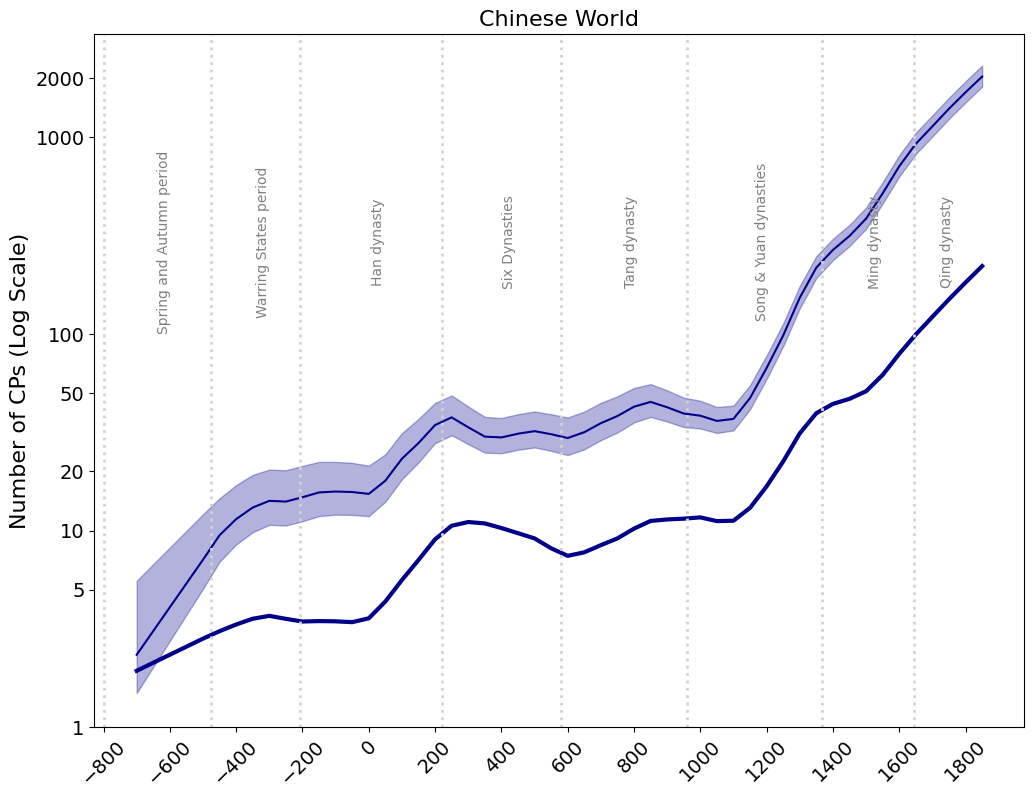

In [32]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south_china.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]
df_cultura = df_cultura[df_cultura['decade']>=-800]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1850]
df_individuals = df_individuals[df_individuals['decade']>=-800]


df_individuals = df_individuals[df_individuals['region_name'].isin(['Chinese world'])]
df_individuals.sort_values('score', ascending=False)


# Filtering logic
df = df_cultura[df_cultura['region_name'].isin(['Chinese world'])]
df = df[df['decade'] >= -800]
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
df['score'] = np.log(1+df['score'])  # Max bound log


# Define your color scheme
colors = {
    "Chinese world": "#00008b",
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')



# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=0.2)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)


        # LOESS smoothing
    smoothed = lowess(region_data['score'], region_data['decade'], frac=0.2)
    # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
    # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 3,linestyle='-')


period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')


# Define specific y-ticks and convert them to log scale for plotting
yticks = [1, 5, 10, 20, 50, 100, 1000, 2000]
yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Number of CPs (Log Scale)', fontsize = 16)
ax.set_title('Chinese World', fontsize = 16)
ax.legend().remove()
plt.show()


### Western Europe

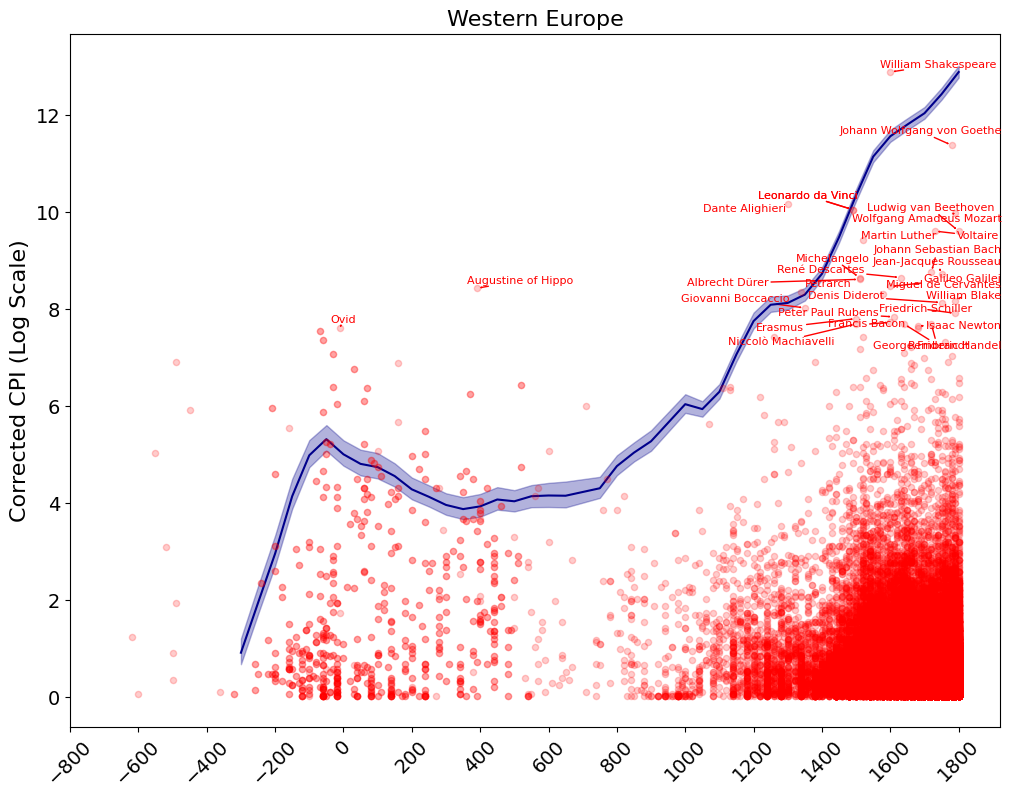

In [7]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south_china.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
#df_cultura = df_cultura[df_cultura['decade']>=600]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
#df_individuals = df_individuals[df_individuals['decade']>=600]


list(set(df_cultura.region_name))

regions_eu = ['Latin World',
 'Portugal',
 'Italy',
#  'Greek World',
 'Spain',
 'Nordic countries',
 'German world',
 'Low countries',
 'France',
 'United Kingdom']


df_cultura = df_cultura[df_cultura['region_name'].isin(regions_eu)]
df_cultura = df_cultura.groupby('decade').sum().reset_index()

df_individuals =df_individuals[df_individuals['region_name'].isin(regions_eu)]


df_cultura['region_name']='Western Europe'
df_individuals['region_name']='Western Europe'

df_individuals.sort_values('score', ascending=False)

df = df_cultura.copy()


# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log


# Define your color scheme
colors = {
    "Western Europe": "#00008b",
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=0.1)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.1)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.1)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(30).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20, zorder=3)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color='red',fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Western Europe', fontsize = 16)
ax.legend().remove()
plt.show()





In [8]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
#df_cultura = df_cultura[df_cultura['decade']>=600]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
#df_individuals = df_individuals[df_individuals['decade']>=600]


df_cultura = df_cultura[df_cultura['region_name'].isin(['Northwestern Europe','Southwestern Europe'])]
df_individuals =df_individuals[df_individuals['region_name'].isin(['Northwestern Europe','Southwestern Europe'])]

df_individuals.sort_values('score', ascending=False)


,individual_wikidata_id,productive_year,decade,individual_name,score,region_name
520510,Q692,1599.0,1600,William Shakespeare,350,Northwestern Europe
470404,Q5879,1784.0,1780,Johann Wolfgang von Goethe,309,Northwestern Europe
19535,Q1067,1300.0,1300,Dante Alighieri,276,Southwestern Europe
539145,Q762,1487.0,1490,Leonardo da Vinci,273,Southwestern Europe
251996,Q254,1791.0,1790,Wolfgang Amadeus Mozart,271,Northwestern Europe
...,...,...,...,...,...,...
477659,Q60023625,1766.0,1770,Mihael Werdnigg,1,Northwestern Europe
477654,Q60023543,1705.0,1700,Martin Wiser,1,Northwestern Europe
274813,Q28361476,1777.0,1780,John Thomas,1,Northwestern Europe
477637,Q60023048,1576.0,1580,Philippe van der Cammen,1,Northwestern Europe


In [9]:
df = df_cultura.copy()


# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
list(set(df['region_name']))


['Southwestern Europe', 'Northwestern Europe']

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_82832/3741569031.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.sort_values(by='decade', inplace=True)


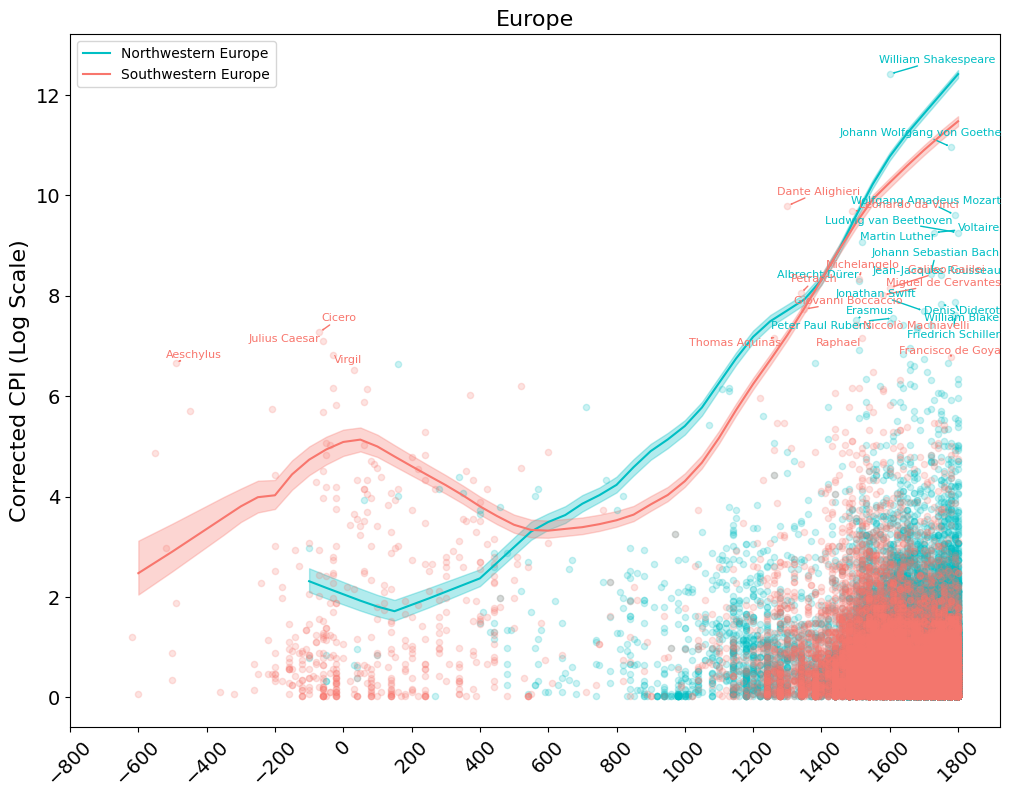

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from adjustText import adjust_text

# Assuming data loading and preparation as done previously in your script

# Define your color scheme
colors = {
    "Northwestern Europe": "#00bfc4",
    "Southwestern Europe": "#f8766d"
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing

    frac = 0.25
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(15).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color=colors[region],fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))


# period_data = {
#     "x_intercepts": [
#         [-800, -476],
#         [-476, -206],
#         [-206, 220],
#         [220, 581],
#         [581, 960],
#         [960, 1368],
#         [1368, 1644],
#         [1644, 1800]
#     ],
#     "labels": [
#         "Spring and Autumn period",
#         "Warring States period",
#         "Han dynasty",
#         "Six Dynasties",
#         "Tang dynasty",
#         "Song & Yuan dynasties",
#         "Ming dynasty",
#         "Qing dynasty"
#     ]
# }

# # Adding labels and vertical lines for each period
# for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
#     start, end = intercept
#     midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
#     # Add vertical line at the start of each period
#     ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
#     # Add text label at the midpoint of the period, shifted upwards
#     ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Europe', fontsize = 16)
ax.legend()
plt.show()


#### Persian World and Arabic World

In [11]:
df_cultura = pd.read_csv("../results_50/raw_results_north_south.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
#df_cultura = df_cultura[df_cultura['decade']>=600]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
#df_individuals = df_individuals[df_individuals['decade']>=600]


regions = ['Persian world','Arabic world']


df_cultura = df_cultura[df_cultura['region_name'].isin(regions)]
df_individuals =df_individuals[df_individuals['region_name'].isin(regions)]

df_individuals.sort_values('score', ascending=False)

df = df_cultura.copy()


# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
list(set(df['region_name']))


['Arabic world', 'Persian world']

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_82832/337027310.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.sort_values(by='decade', inplace=True)


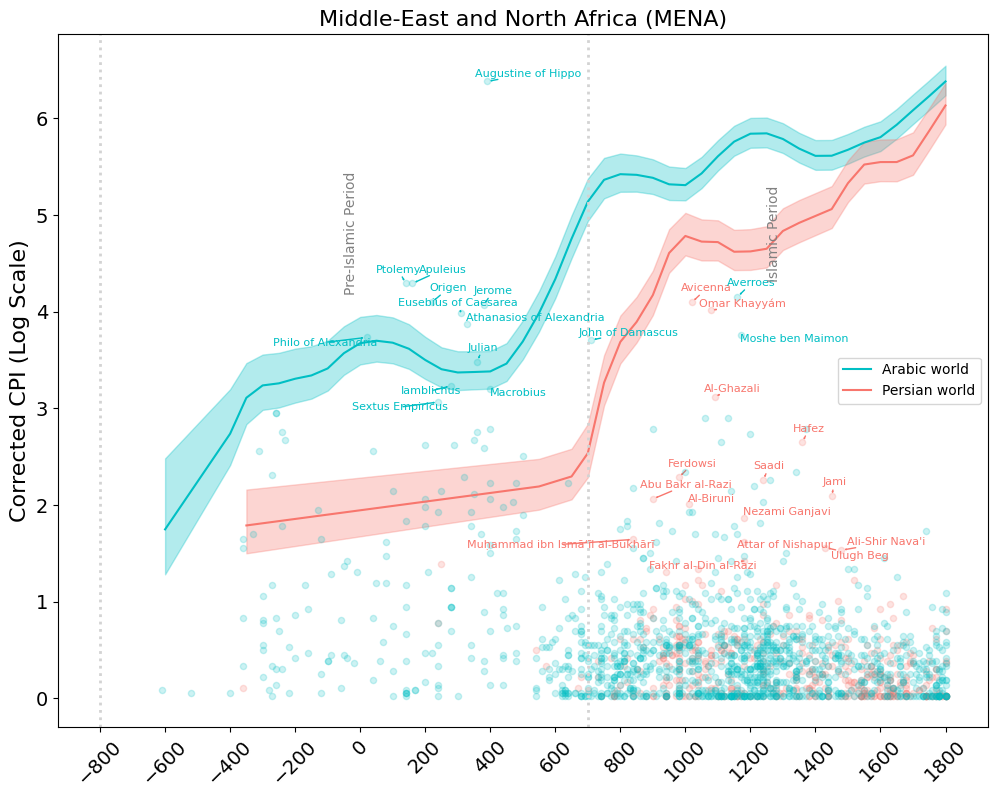

In [12]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from adjustText import adjust_text

# Assuming data loading and preparation as done previously in your script

# Define your color scheme
colors = {
    "Arabic world": "#00bfc4",
    "Persian world": "#f8766d"
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing

    frac = 0.2
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(15).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color=colors[region],fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))


period_data = {
    "x_intercepts": [
        [-800, 700],
        [700, 1800],
    
    ],
    "labels": [
        "Pre-Islamic Period",
        "Islamic Period",
    ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Middle-East and North Africa (MENA)', fontsize = 16)
ax.legend()
plt.show()


In [13]:
df_cultura = pd.read_csv("../results_50/raw_results_north_south_13_09.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
#df_cultura = df_cultura[df_cultura['decade']>=600]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
#df_individuals = df_individuals[df_individuals['decade']>=600]


regions = ['Southern Japan','Northern Japan']


df_cultura = df_cultura[df_cultura['region_name'].isin(regions)]
df_individuals =df_individuals[df_individuals['region_name'].isin(regions)]

df_individuals.sort_values('score', ascending=False)

df = df_cultura.copy()
df = df[df['decade']>=700]

df_individuals = df_individuals[df_individuals['decade']>=700]

# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
list(set(df['region_name']))


['Northern Japan', 'Southern Japan']

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_82832/1541530836.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.sort_values(by='decade', inplace=True)


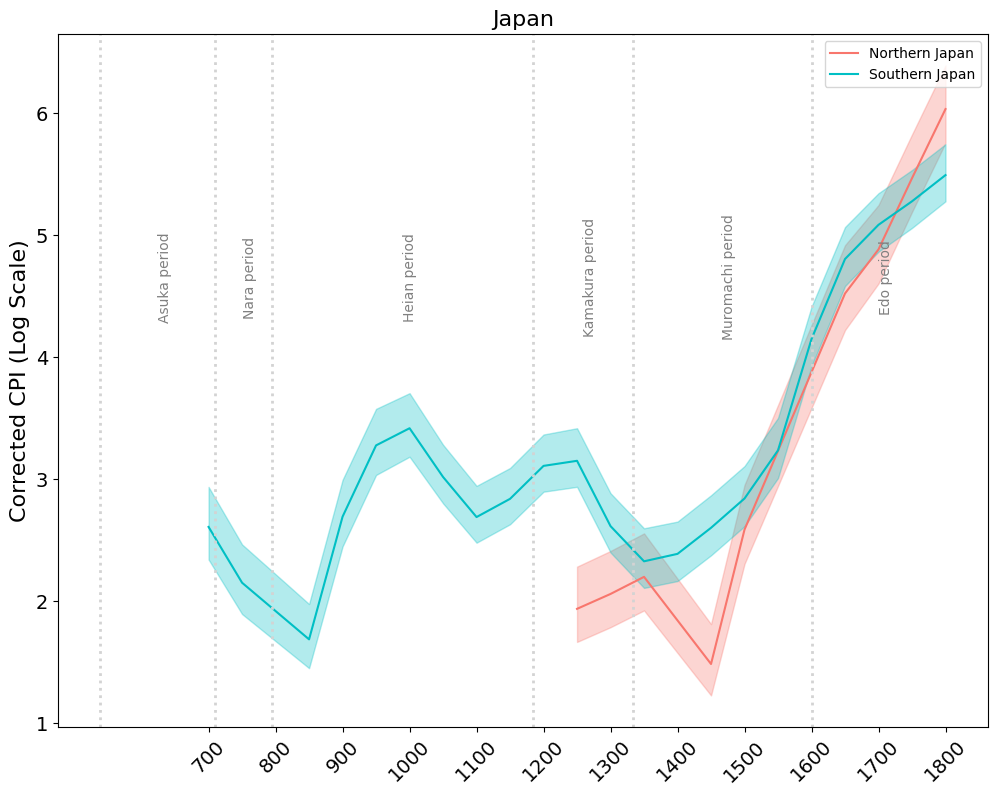

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from adjustText import adjust_text

# Assuming data loading and preparation as done previously in your script

# Define your color scheme
colors = {
    "Southern Japan": "#00bfc4",
    "Northern Japan": "#f8766d"
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing

    frac = 0.2
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# # Collect texts from each region separately and adjust
# for region in df_individuals['region_name'].unique():
#     region_individuals = df_individuals[df_individuals['region_name'] == region]
#     region_individuals = region_individuals.sort_values('score', ascending=False)
#     top_individuals = region_individuals.head(15).sort_values('score', ascending=False)
#     texts = []  # Initialize a new list for this region's texts

#     # Plot scatter for all individuals
#     all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
#     ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

#     # Texts for top 15
#     for _, row in top_individuals.iterrows():
#         score_normalized = (row['score'] / max_global_score) * max_n_est
#         text = ax.text(row['decade'], score_normalized, row['individual_name'], 
#                        ha='center', va='bottom', color=colors[region],fontsize=8)
#         texts.append(text)

#     # Use adjust_text for the current region with the corresponding arrow color
#     adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))


period_data = {
    "x_intercepts": [
       [
                    538,
                    710
                ],
                [
                    710,
                    794
                ],
                [
                    794,
                    1185
                ],
                [
                    1185,
                    1333
                ],
                [
                    1333,
                    1600
                ],
                [
                    1600,
                    1800
                ]
            ],

    "labels": [
                "Asuka period",
                "Nara period",
                "Heian period",
                "Kamakura period",
                "Muromachi period",
                "Edo period"
            ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(700, 1801, 100))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Japan', fontsize = 16)
ax.legend()
plt.show()


In [15]:
df_cultura = pd.read_csv("../results_50/raw_results_north_south_13_09.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
#df_cultura = df_cultura[df_cultura['decade']>=600]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
#df_individuals = df_individuals[df_individuals['decade']>=600]


regions = ['Japan']


df_cultura = df_cultura[df_cultura['region_name'].isin(regions)]
df_individuals =df_individuals[df_individuals['region_name'].isin(regions)]

df_individuals.sort_values('score', ascending=False)

df = df_cultura.copy()
df = df[df['decade']>=700]

df_individuals = df_individuals[df_individuals['decade']>=700]

# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
list(set(df['region_name']))


['Japan']

In [34]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv("../results_50/raw_results_north_south_china.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual


df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]
df_cultura = df_cultura[df_cultura['decade']>=600]

df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1850]
df_individuals = df_individuals[df_individuals['decade']>=600]


list(set(df_cultura.region_name))

regions_eu = ['Japan']


df_cultura = df_cultura[df_cultura['region_name'].isin(regions_eu)]

df_individuals =df_individuals[df_individuals['region_name'].isin(regions_eu)]

df_cultura['N_est'].sum()


836/7839


0.10664625589998725

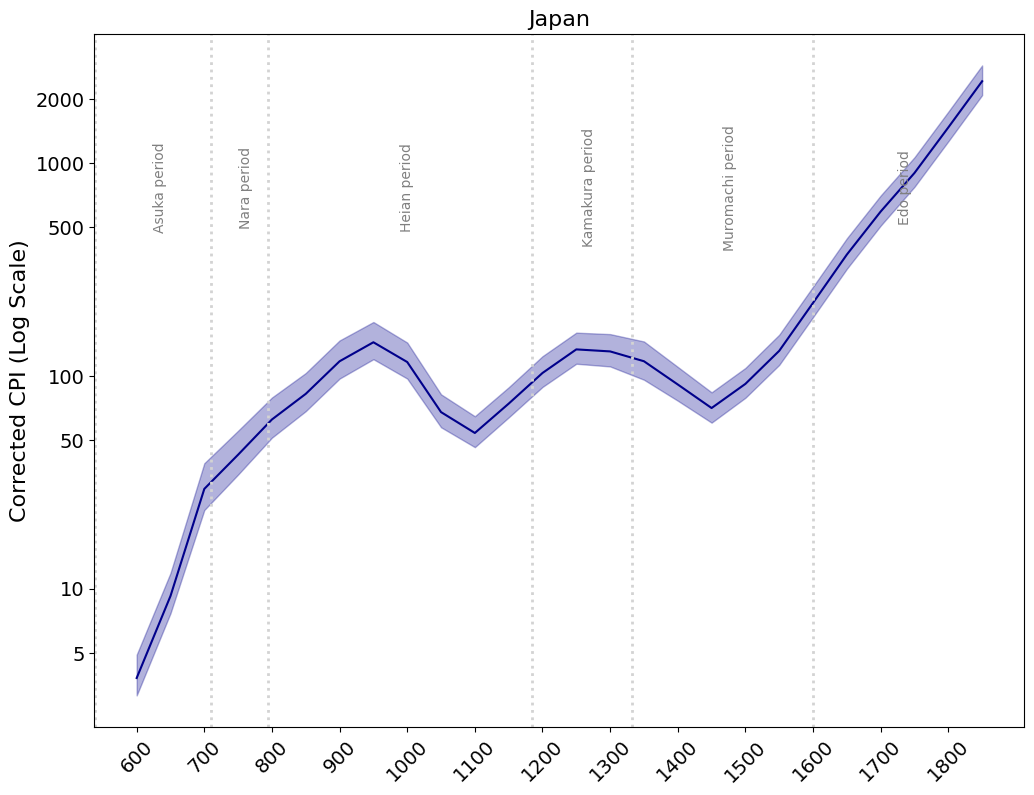

In [35]:





df_individuals.sort_values('score', ascending=False)

df = df_cultura.copy()


# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log


# Define your color scheme
colors = {
    "Japan": "#00008b",
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')


frac_value =0.2

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac_value)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac_value)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac_value)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# # Collect texts from each region separately and adjust
# for region in df_individuals['region_name'].unique():
#     region_individuals = df_individuals[df_individuals['region_name'] == region]
#     region_individuals = region_individuals.sort_values('score', ascending=False)
#     top_individuals = region_individuals.head(30).sort_values('score', ascending=False)
#     texts = []  # Initialize a new list for this region's texts

#     # Plot scatter for all individuals
#     all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
#     ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20)

#     # Texts for top 15
#     for _, row in top_individuals.iterrows():
#         score_normalized = (row['score'] / max_global_score) * max_n_est
#         text = ax.text(row['decade'], score_normalized, row['individual_name'], 
#                        ha='center', va='bottom', color='red',fontsize=8)
#         texts.append(text)

#     # Use adjust_text for the current region with the corresponding arrow color
#     adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))


period_data = {
    "x_intercepts": [
       [
                    538,
                    710
                ],
                [
                    710,
                    794
                ],
                [
                    794,
                    1185
                ],
                [
                    1185,
                    1333
                ],
                [
                    1333,
                    1600
                ],
                [
                    1600,
                    1850
                ]
            ],

    "labels": [
                "Asuka period",
                "Nara period",
                "Heian period",
                "Kamakura period",
                "Muromachi period",
                "Edo period"
            ]
}

# Adding labels and vertical lines for each period
for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
    start, end = intercept
    midpoint = (start + end) / 2  # Calculate the midpoint of each period
    
    # Add vertical line at the start of each period
    ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
    
    # Add text label at the midpoint of the period, shifted upwards
    ax.text(midpoint, ax.get_ylim()[1] * 0.8, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



# Define specific y-ticks and convert them to log scale for plotting
yticks = [5, 10, 50, 100, 500, 1000, 2000]
yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(600, 1860, 100))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Japan', fontsize = 16)



ax.legend().remove()
plt.show()



